# Implementing a PINN to solve the Paraxial Helmholtz equation

### The Paraxial Helmholtz equation

The Paraxial Helmholtz equation (PHE) is given by

$$ \nabla_T^2 A(x,y,z) - 2ik \partial_z A(x,y,z) = 0, $$

where $\nabla_T^2$ is the transverse laplacian.

First thing we do is to throw out the $y$ dimension. This unfortunately is not as trivial as just deleting the $\partial^2_y$ and doing $y=0$. After some thinking I figured out that for the solution

$$ A(x,z) = \frac{A_0}{z} \exp\left[-ikx^2 / (2z)\right] $$

we need to adjust our differential equation by

$$ \frac{\partial^2 }{\partial x^2} A(x,z) - 2ik \partial_z A(x,z) = i\frac{k}{z} A(x,z) $$

Now we separate the PDE into real and imaginary part, where $A(x,z) := u(x,z) + i\cdot v(x,z)$:

$$ \frac{\partial^2 }{\partial x^2} u(x,z) + 2k\partial_z v(x,z) + \frac{k}{z}v(x,z) + i\cdot \left( \frac{\partial^2 }{\partial x^2} v(x,z) - \frac{k}{z} u(x,z) - 2k\partial_z u(x,z) \right) = 0$$

This leaves us with two coupled equations which will form the basis of our PINN:

\begin{align}
0 &=  \frac{\partial^2 }{\partial x^2} u(x,z) + \frac{k}{z} v(x,z) + 2k\partial_z v(x,z) \\
0 &=  \frac{\partial^2 }{\partial x^2} v(x,z) - \frac{k}{z} u(x,z) - 2k\partial_z u(x,z)
\end{align}

### Reference solution: The paraxial wave

The reference solution is the spherical wave in paraxial approximation:

$$ A(x,z) = \frac{A_0}{z} \exp\left[-ikx^2 / (2z)\right] $$

Again, we split into imaginary and real part according to $A(x,z) := u(x,z) + i\cdot v(x,z)$:

$$ A(x,z) = \frac{A_0}{z} \cos (kx^2 / (2z)) - i \cdot \frac{A_0}{z} \sin (kx^2 / (2z)) $$

and receive

\begin{align}
u(x,z) &= \frac{A_0}{z} \cos(kx^2 / (2z)) \\
v(x,z) &= - \frac{A_0}{z} \sin(kx^2 / (2z))
\end{align}

#### Boundary conditions

We choose as boundaries $x \in [-1,1]$ and $z \in [1,2]$. This gives

\begin{align}
u(\pm 1, z) &=  \frac{A_0}{z} \cos(k/(2z)) \\
v(\pm 1, z) &= -\frac{A_0}{z} \sin(k/(2z))
\end{align}

and

\begin{align}
u(x,1) &= A_0 \cos(kx^2/2) \\
v(x,1) &= -A_0 \sin(kx^2/2) 
\end{align}

#### Choosing the physical parameters

We choose $A_0 = 1$ and $k = 5$. The reason can be simply explained by plotting $u(x,1)$ (see a little later).

### Implementation - Hyperparameters

We use $4$ layers with $32$ nodes each.

# Code

### Importing stuff

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
from time import time

### Setting seed, backend and other setup conveniences

In [2]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
plt.rcParams['axes.grid'] = False   # otherwise he dislikes colorplots

In [4]:
tf.random.set_seed(42) # always the same seed - reproducibility

In [5]:
pi = tf.constant(np.pi, dtype=DTYPE) # everybody needs some pi in their life

In [6]:
images = []  # container to store output images in order to create GIF

In [7]:
mpl.matplotlib_fname() # sanity check - where's my matplotlibrc

'C:\\Users\\Jakob\\.matplotlib\\matplotlibrc'

### Setting physical constants

In [8]:
A_0 = 1.
k = 5.

x_lb = -1.
x_ub = 1.

z_lb = 1.
z_ub = 2.

### Plotting the solution beforehand

In [9]:
def u_exact_np(x, z):
    return (A_0 / z) * np.cos(0.5 * k * x**2 / z)

def v_exact_np(x, z):
    return (- A_0 / z) * np.sin(0.5 * k * x**2 / z)

In [56]:
def u_dx_exact_np(x, z):
    return -(A_0 * x * k / z**2) * np.sin(0.5 * k * x**2 / z)

def v_dx_exact_np(x, z):
    return (- A_0 * x * k / z**2) * np.sin(0.5 * k * x**2 / z)

def u_dx2_exact_np(x, z):
    return -(A_0 * k / z**2) * np.sin(0.5 * k * x**2 / z) - (A_0 * k**2 * x**2 / z**3) * np.cos(0.5 * k * x**2 / z)

def v_dz_exact_np(x, z):
    return (0.5 * A_0 / z**3) * (2*np.sin(0.5 * k * x**2 / z) * z + k*x**2*np.cos(0.5*k*x**2 / z))

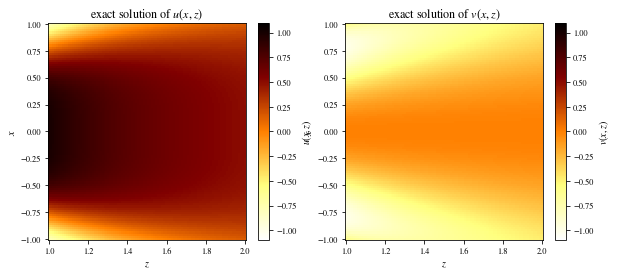

In [11]:
x_np = np.linspace(-1, 1, num=100)
z_np = np.linspace(1, 2, num=100)

x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

line1 = ax1.pcolormesh(z_npmesh, x_npmesh, u_exact_np(x_npmesh, z_npmesh), vmin=-1.1, vmax=1.1, cmap = cm.afmhot_r)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
ax1.set_title('exact solution of $u(x,z)$')
cmap1 = fig.colorbar(line1, ax=ax1)
cmap1.set_label('$u(x,z)$')

line2 = ax2.pcolormesh(z_npmesh, x_npmesh, v_exact_np(x_npmesh, z_npmesh), vmin=-1.1, vmax=1.1, cmap = cm.afmhot_r)
ax2.set_xlabel('$z$')
ax2.set_ylabel('$x$')
ax2.set_title('exact solution of $v(x,z)$')
cmap2 = fig.colorbar(line2, ax=ax2)
cmap2.set_label('$v(x,z)$')
plt.show()

In [12]:
plt.close()

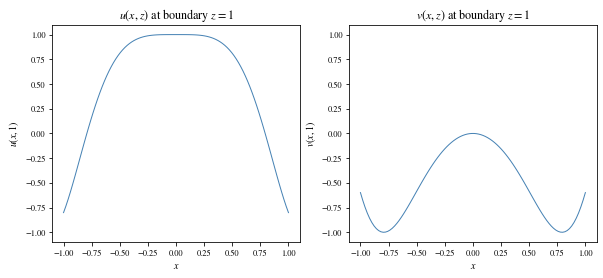

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

ax1.plot(x_npmesh[0,:], u_exact_np(x_npmesh, z_npmesh)[0,:])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(x,1)$')
ax1.set_ylim(-1.1, 1.1)
ax1.set_title('$u(x,z)$ at boundary $z=1$')

ax2.plot(x_npmesh[0,:], v_exact_np(x_npmesh, z_npmesh)[0,:])
ax2.set_xlabel('$x$')
ax2.set_ylabel('$v(x,1)$')
ax2.set_ylim(-1.1, 1.1)
ax2.set_title('$v(x,z)$ at boundary $z=1$')

plt.show()

In [14]:
plt.close()

**This explains the choice $k=5$ in the beginning - for the first tries, we want to avoid too much complexity.** 

When the model works, we can increase $k$ in order to induce more oscillations.

### Determine neural network parameters

In [32]:
Nx = 1000   # Nx and Nt should be the same, else we
Nz = 1000   # get a ragged tensor and nobody wants that

Nx_test = 100
Nz_test = 100

Nbx = 100   # these do not have to
Nbz = 100   # be the same size

### Create all input

In [33]:
# boundaries as tf constants

lb = tf.constant([x_lb, z_lb], dtype=DTYPE)
ub = tf.constant([x_ub, z_ub], dtype=DTYPE)

# x and z collocation points for PDE residual

x = tf.random.uniform((Nx, 1), x_lb, x_ub, dtype=DTYPE)
z = tf.random.uniform((Nz, 1), z_lb, z_ub, dtype=DTYPE)
XZ = tf.concat([x, z], axis=1)

xtest = np.linspace(x_lb, x_ub, Nx_test)
ztest = np.linspace(z_lb, z_ub, Nz_test)
xtestm, ztestm = np.meshgrid(xtest, ztest)
xtestm_resh = xtestm.flatten().reshape(Nx_test*Nz_test, 1)
ztestm_resh = ztestm.flatten().reshape(Nx_test*Nz_test, 1)

xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)
XZtest = tf.concat([xtestm_resh_tf, ztestm_resh_tf], axis=1)

# x and z for z boundary condition
    # note that z = 1 in our case is like an initial condition
    # and is thus treated as such

z0 = tf.ones((Nbz, 1), dtype=DTYPE)
x0 = tf.random.uniform((Nbz, 1), x_lb, x_ub, dtype=DTYPE)
XZ0 = tf.concat([x0, z0], axis=1)

# x and z for x boundary conditions

zb = tf.random.uniform((Nbx, 1), z_lb, z_ub, dtype=DTYPE)
xlb = tf.ones((Nbx, 1), dtype=DTYPE) * x_lb
XZlb = tf.concat([xlb, zb], axis=1)
xub = tf.ones((Nbx, 1), dtype=DTYPE) * x_ub
XZub = tf.concat([xlb, zb], axis=1)

### Create all functions for tensorflow

In [34]:
# FUNCTION u

def u_init(x0):
    return A_0 * tf.cos(k * x0**2 / 2)

def u_bound_lb(zb):
    return A_0 / zb * tf.cos(k * x_lb**2 / (2*zb))

def u_bound_ub(zb):
    return A_0 / zb * tf.cos(k * x_ub**2 / (2*zb))

# FUNCTION v

def v_init(x0):
    return - (A_0 * tf.sin(k * x0**2 / 2))

def v_bound_lb(zb):
    return - (A_0 / zb * tf.sin(k * x_lb**2 / (2*zb)))

def v_bound_ub(zb):
    return - (A_0 / zb * tf.sin(k * x_ub**2 / (2*zb)))

### Function to initialize model

In [35]:
def init_model(L = 4, N = 32):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))
    for _ in range(L):
        model.add(tf.keras.layers.Dense(N,
                                       activation=tf.keras.activations.get('tanh'), # why not ReLu?
                                       kernel_initializer='glorot_normal')) # why not random?
    model.add(tf.keras.layers.Dense(2)) # 2d output (u and v)
    return model

### Function to return the PDE residuals ("physics")

In [36]:
def physics(model, XZ):
    with tf.GradientTape(persistent=True) as tape:
        x, z = XZ[:, 0:1], XZ[:, 1:2]
        
        tape.watch(x)
        tape.watch(z)
        
        A = model((tf.stack([x[:,0], z[:,0]], axis=1)))
        u = A[:, 0:1]
        v = A[:, 1:2]
        u_dx = tape.gradient(u, x)
        v_dx = tape.gradient(v, x)
        
    u_dz = tape.gradient(u, z)
    u_dx2 = tape.gradient(u_dx, x)
    v_dz = tape.gradient(v, z)
    v_dx2 = tape.gradient(v_dx, x)
    
    del tape
      
    real_resid = u_dx2 + 2 * k * v_dz + (k / z) * v 
    imag_resid = v_dx2 - 2 * k * u_dz - (k / z) * u

    return real_resid, imag_resid

### Function to compute loss

In [37]:
def compute_loss(model, XZ, XZ0, XZlb, XZub, phylr):
    real_resid, imag_resid = physics(model, XZ)
    
    A_init_pred = model(XZ0)
    A_lb_pred = model(XZlb)
    A_ub_pred = model(XZub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_lb_pred = A_lb_pred[:, 0:1]
    u_ub_pred = A_ub_pred[:, 0:1]
    
    v_init_pred = A_init_pred[:, 1:2]
    v_lb_pred = A_lb_pred[:, 1:2]
    v_ub_pred = A_ub_pred[:, 1:2]
    
    u0_exact = u_init(XZ0[:,0:1]) # BUGGY? SHOULD BE [:,0:1]
    u_lb_exact = u_bound_lb(XZlb[:,1:2]) # BUGGY? SHOULD BE [:,1:2]
    u_ub_exact = u_bound_ub(XZub[:,1:2]) # BUGGY? SHOULD BE [:,1:2]
    
    v0_exact = v_init(XZ0[:,0:1]) # BUGGY? SHOULD BE [:,0:1]
    v_lb_exact = v_bound_lb(XZlb[:,1:2]) # BUGGY? SHOULD BE [:,1:2]
    v_ub_exact = v_bound_ub(XZub[:,1:2]) # BUGGY? SHOULD BE [:,1:2]
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0]
    u_phi_lb = tf.reduce_mean(tf.square(u_lb_exact - u_lb_pred)) * phylr[1]
    u_phi_ub = tf.reduce_mean(tf.square(u_ub_exact - u_ub_pred)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi_lb = tf.reduce_mean(tf.square(v_lb_exact - v_lb_pred)) * phylr[1]
    v_phi_ub = tf.reduce_mean(tf.square(v_ub_exact - v_ub_pred)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi_lb + u_phi_ub
    v_phi_bound = v_phi_lb + v_phi_ub
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
    
    # fucking hell I need a dictionary for that
    
    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

### Function to get gradients

In [38]:
def get_grad(model, XZ, XZ0, XZlb, XZub, phylr = [5e-4, 1, 1]):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss(model, XZ, XZ0, XZlb, XZub, phylr)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, g

### Function to execute one full training step

In [39]:
#@tf.function
def trainstep():
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, grad_theta = get_grad(model, XZ, XZ0, XZlb, XZub)
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return  loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

### Function to do plotting

In [54]:
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

def plot_model(epoch):
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = u_plot_pre.numpy().reshape(Nx_test, Nz_test)
    v_plot = v_plot_pre.numpy().reshape(Nx_test, Nz_test)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), dpi=500)
    line1 = ax1.pcolormesh(ztestm, xtestm, u_plot, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
    cbar1 = fig.colorbar(line1, ax=ax1)
    cbar1.set_label(r'$u(x,z)$')
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x$')
    ax1.text(1.95, -0.9, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    line2 = ax2.pcolormesh(ztestm, xtestm, v_plot, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
    cbar2 = fig.colorbar(line2, ax=ax2)
    cbar2.set_label(r'$v(x,z)$')
    ax2.set_xlabel(r'$z$')
    ax2.set_ylabel(r'$x$')
    ax2.text(1.95, -0.9, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    fig.subplots_adjust(wspace=0.25)
    fig.savefig(f'epochs_paraxialwaves/{epoch}.png')
    images.append(imageio.imread(f'epochs_paraxialwaves/{epoch}.png'))
    plt.close()

### Initialize model, create boundaries, choose optimizer

In [41]:
model = init_model()
boundaries, values = [1000, 3000], [1e-3, 1e-3, 1e-3]
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

### Do some setup before the loop

In [42]:
epoch = 0
loss = 1.
t0 = time()

maxepoch = 10000
loss_epoch = []
real_physics_loss_epoch = []
u_bound_loss_epoch = []
u_initial_loss_epoch = []
imag_physics_loss_epoch = []
v_bound_loss_epoch = []
v_initial_loss_epoch = []
phylr = [5e-4, 5, 1]

### The loop

In [43]:
while loss > 1e-5 and epoch < maxepoch:
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = trainstep()
    loss_epoch.append(loss)
    real_physics_loss_epoch.append(real_phi_pde)
    u_bound_loss_epoch.append(u_phi_bound)
    u_initial_loss_epoch.append(u_phi_i)
    imag_physics_loss_epoch.append(imag_phi_pde)
    v_bound_loss_epoch.append(v_phi_bound)
    v_initial_loss_epoch.append(v_phi_i)
    
    if epoch % 100 == 0:
        plot_model(epoch)
        print(f'Elapsed time: {time()-t0:.0f} s')
        print(f'  Currently on iteration {epoch}')
        print(f'  Loss: {loss:.6f} with real loss {real_phi_pde:.6f}, imaginary loss {imag_phi_pde:.6f}')
        print(f'    and u bound loss {u_phi_bound:.6f}, u init loss {u_phi_i:.6f}')    
        print(f'    and v bound loss {v_phi_bound:.6f}, v init loss {v_phi_i:.6f}')
    epoch += 1

Elapsed time: 2 s
  Currently on iteration 0
  Loss: 1.411983 with real loss 0.014242, imaginary loss 0.000137
    and u bound loss 0.358383, u init loss 0.686813
    and v bound loss 0.183473, v init loss 0.168934
Elapsed time: 9 s
  Currently on iteration 100
  Loss: 0.212151 with real loss 0.003746, imaginary loss 0.013608
    and u bound loss 0.021539, u init loss 0.124893
    and v bound loss 0.000836, v init loss 0.047527
Elapsed time: 17 s
  Currently on iteration 200
  Loss: 0.068773 with real loss 0.000560, imaginary loss 0.008931
    and u bound loss 0.008266, u init loss 0.030944
    and v bound loss 0.001861, v init loss 0.018210
Elapsed time: 24 s
  Currently on iteration 300
  Loss: 0.039865 with real loss 0.001292, imaginary loss 0.003201
    and u bound loss 0.001101, u init loss 0.017378
    and v bound loss 0.000890, v init loss 0.016004
Elapsed time: 31 s
  Currently on iteration 400
  Loss: 0.027639 with real loss 0.001957, imaginary loss 0.002348
    and u bound lo

Elapsed time: 258 s
  Currently on iteration 3400
  Loss: 0.000121 with real loss 0.000030, imaginary loss 0.000051
    and u bound loss 0.000010, u init loss 0.000008
    and v bound loss 0.000003, v init loss 0.000019
Elapsed time: 265 s
  Currently on iteration 3500
  Loss: 0.000114 with real loss 0.000029, imaginary loss 0.000049
    and u bound loss 0.000007, u init loss 0.000007
    and v bound loss 0.000005, v init loss 0.000018
Elapsed time: 273 s
  Currently on iteration 3600
  Loss: 0.000104 with real loss 0.000027, imaginary loss 0.000046
    and u bound loss 0.000007, u init loss 0.000006
    and v bound loss 0.000001, v init loss 0.000016
Elapsed time: 280 s
  Currently on iteration 3700
  Loss: 0.000099 with real loss 0.000026, imaginary loss 0.000044
    and u bound loss 0.000006, u init loss 0.000006
    and v bound loss 0.000001, v init loss 0.000015
Elapsed time: 288 s
  Currently on iteration 3800
  Loss: 0.000094 with real loss 0.000025, imaginary loss 0.000042
    

Elapsed time: 547 s
  Currently on iteration 7200
  Loss: 0.000038 with real loss 0.000011, imaginary loss 0.000017
    and u bound loss 0.000003, u init loss 0.000004
    and v bound loss 0.000000, v init loss 0.000004
Elapsed time: 554 s
  Currently on iteration 7300
  Loss: 0.000037 with real loss 0.000011, imaginary loss 0.000017
    and u bound loss 0.000003, u init loss 0.000003
    and v bound loss 0.000001, v init loss 0.000003
Elapsed time: 562 s
  Currently on iteration 7400
  Loss: 0.000359 with real loss 0.000010, imaginary loss 0.000017
    and u bound loss 0.000219, u init loss 0.000040
    and v bound loss 0.000047, v init loss 0.000026
Elapsed time: 570 s
  Currently on iteration 7500
  Loss: 0.000033 with real loss 0.000010, imaginary loss 0.000016
    and u bound loss 0.000001, u init loss 0.000002
    and v bound loss 0.000000, v init loss 0.000003
Elapsed time: 577 s
  Currently on iteration 7600
  Loss: 0.000034 with real loss 0.000010, imaginary loss 0.000016
    

In [55]:
plot_model(epoch)

### Plotting of results

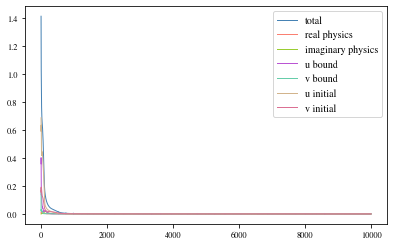

In [45]:
plt.plot(loss_epoch, label='total')
plt.plot(real_physics_loss_epoch, label='real physics')
plt.plot(imag_physics_loss_epoch, label='imaginary physics')
plt.plot(u_bound_loss_epoch, label='u bound')
plt.plot(v_bound_loss_epoch, label='v bound')
plt.plot(u_initial_loss_epoch, label='u initial')
plt.plot(v_initial_loss_epoch, label='v initial')
#plt.ylim(0, 0.001)
plt.legend(loc='upper right')

In [46]:
plt.close()

In [51]:
imageio.mimsave('diffraction2D.gif',images,fps=20)

<img src="diffraction2D.gif?1" width="750" align="center">

### Testing ground

In [50]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Checklist of bugfixing

### check physics

- [x] PDEs correct?
- [x] implementation correct?

### check code

- [x] plotting correct?
- [x] check every damn line of code (yay)

### does it work?

- [x] yes